In [1]:
# At the beginning of your script or notebook
# %load_ext autoreload
# %autoreload 2

import os
import random
from IPython.display import HTML, display

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Third-party library imports
import torch
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split

# Local imports
from src import *
from src.visualization import _combine_html_contents, _light_mode

probes_folder = "./probe_weights_comp_only" # Set this to a cache directory where probe weights will be stored

Triton not installed, using eager implementation of SAE decoder.


In [2]:
model_type = "llama3"

if model_type == "llama3":
    encoder = EleutherSparseAutoencoder.load_llama3_sae(12, instruct=True)
    jailbreaks_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks")
elif model_type == "gemma2":
    encoder = DeepmindSparseAutoencoder.load_gemma2_sae(0, 11)
    jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/gemma2-jailbreaks")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def sample_examples_from_datasets(
    datasets, proportions, total_examples=3000, only_prompts=False
):
    # This function samples examples from multiple datasets, ensuring that the final list has the desired proportions
    # of examples from each dataset. The final list is shuffled.

    # Ensure the proportions sum to 1
    if len(datasets) != len(proportions):
        raise ValueError("Number of datasets must match number of proportions")

    if abs(sum(proportions) - 1) > 1e-6:
        raise ValueError("Proportions must sum to 1")

    examples = []
    np.random.seed(42)
    for dataset, proportion in zip(datasets, proportions):
        n_samples = int(total_examples * proportion)

        # Ensure we don't try to sample more examples than available
        sampled_indices = np.random.choice(len(dataset), size=n_samples, replace=True)
        sampled = dataset.select(sampled_indices)

        if only_prompts:
            examples.extend([item["prompt"] for item in sampled])
        else:
            examples.extend(
                [f"{item['prompt']} {item['completion']}" for item in sampled]
            )

    # Shuffle the final list to mix examples from different datasets
    random.Random(42).shuffle(examples)

    return examples


forget_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0]
)

retain_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
)

# Also get examples with just the prompts
forget_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0], only_prompts=True
)

retain_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
    only_prompts=True,
)

### Train Probes

In [4]:
file_name = os.path.join(probes_folder, f"{model_type}_linear_probes.pt")

if os.path.exists(file_name):
    linear_probes = load_probes(file_name)
else:
    linear_probes = train_linear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        only_return_on_tokens_between=[78191, 128009],
    )
    save_probes(linear_probes, file_name)

/nas/ucb/abhay/sae_experiments/src/probe_training.py:805: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(load_path)


In [5]:
file_name = os.path.join(probes_folder, f"{model_type}_quadratic_probes.pt")

if os.path.exists(file_name):
    quadratic_probes = load_probes(file_name)
else:
    quadratic_probes = train_quadratic_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        only_return_on_tokens_between=[78191, 128009],
    )
    save_probes(quadratic_probes, file_name)

In [6]:
file_name = os.path.join(probes_folder, f"{model_type}_mlp_probes.pt")

if os.path.exists(file_name):
    mlp_probes = load_probes(file_name)
else:
    mlp_probes = train_nonlinear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        d_mlp=64,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(mlp_probes, file_name)

In [7]:
file_name = os.path.join(probes_folder, f"{model_type}_attention_probes.pt")

if os.path.exists(file_name):
    attention_probes = load_probes(file_name)
else:
    attention_probes = train_attention_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        d_proj=64,
        nhead=8,
        sliding_window=16,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(attention_probes, file_name)

In [8]:
file_name = os.path.join(probes_folder, f"{model_type}_subspace_probes.pt")

if os.path.exists(file_name):
    subspace_probes = load_probes(file_name)
else:
    subspace_probes = train_subspace_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        subspace_dim=64,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(subspace_probes, file_name)


In [9]:
file_name = os.path.join(probes_folder, f"{model_type}_mean_diff_probes.pt")

if os.path.exists(file_name):
    mean_diff_probes = load_probes(file_name)
else:
    # Compute the steering vectors
    results = compute_steering_vector(
        encoder=encoder,
        positive_examples=forget_examples_train_prompts[:500],
        negative_examples=retain_examples_train_prompts[:500],
        layers=[4, 8, 10, 12, 16, 20, 24],
        position_aggregation="last",
        method="mean_diff",
    )

    # Construct the probes and finetune for callibration
    mean_diff_probes = {
        layer: DirectionalProbe(results[layer]["steering_vector"]) for layer in results
    }
    train_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :3000
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :3000
        ],  # retain examples are now negative
        create_probe_fn=None,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        pretrained_probes=mean_diff_probes,
    )

    save_probes(mean_diff_probes, file_name)

In [10]:
file_name = os.path.join(probes_folder, f"{model_type}_lora_linear_probes.pt")
lora_linear_probes = load_probes(file_name)

### Generate Evaluation Plots

In [11]:
import json
import numpy as np
import os

datasets = [
    "harmful_gcg",
    "harmful_pair",
    "harmful_autodan",
    "harmful_human_mt",
    "harmful_msj",
    "harmful_prefill",
    "harmful_misc",
    "benign_instructions_train",
    "benign_instructions_test",
    "circuit_breakers_train",
    "circuit_breakers_test",
    "or_bench_test",
    "mt_bench",
    "wildchat",
]

linear_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_linear_probes_annotation_dataset.json",
    linear_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

mlp_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_mlp_probes_annotation_dataset.json",
    mlp_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

attention_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_attention_probes_annotation_dataset.json",
    attention_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

mean_diff_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_mean_diff_probes_annotation_dataset.json",
    mean_diff_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

quadratic_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_quadratic_probes_annotation_dataset.json",
    quadratic_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

subspace_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_subspace_probes_annotation_dataset.json",
    subspace_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
)

lora_linear_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_lora_linear_probes_annotation_dataset.json",
    lora_linear_probes,
    encoder,
    jailbreaks_dataset,
    datasets,
    model_adapter_path=os.path.join(probes_folder, "llama3_lora_linear_model"),
)

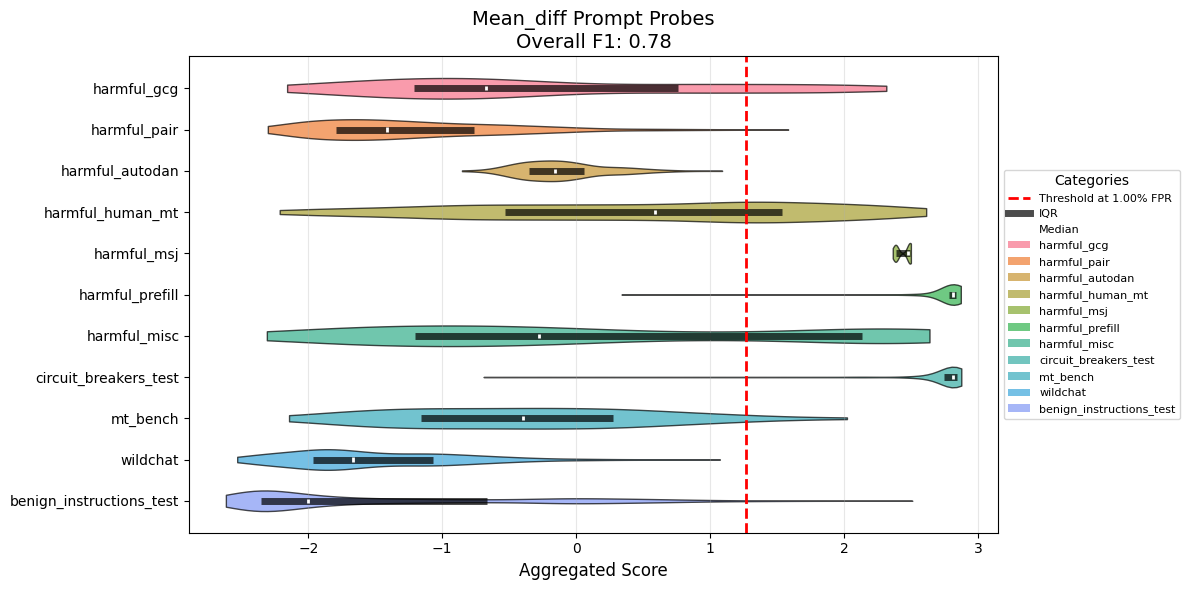

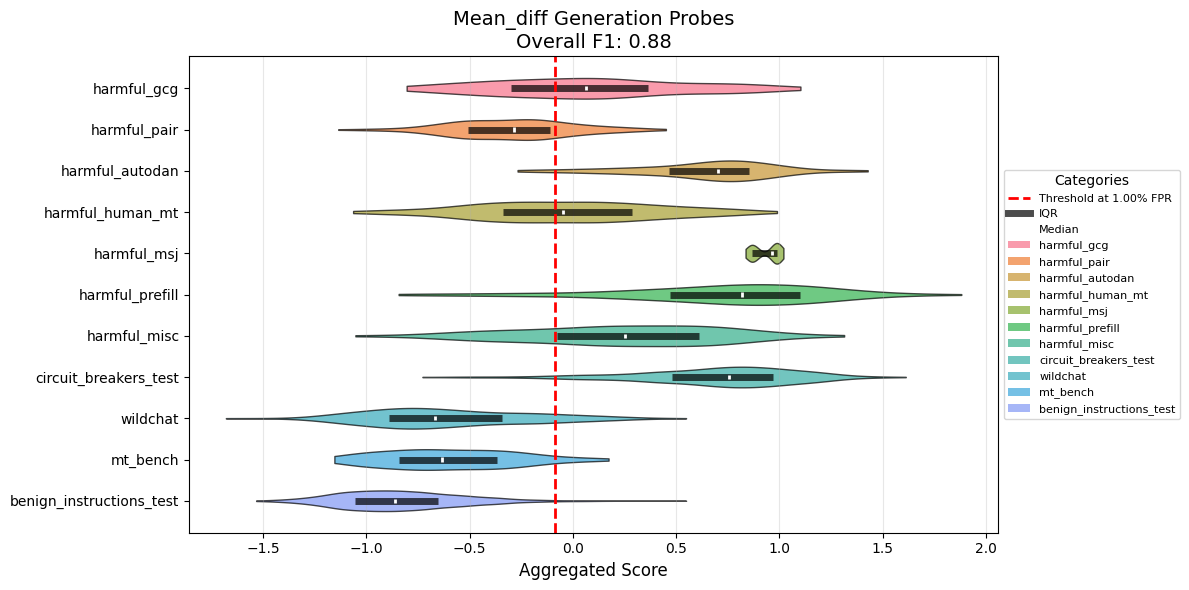

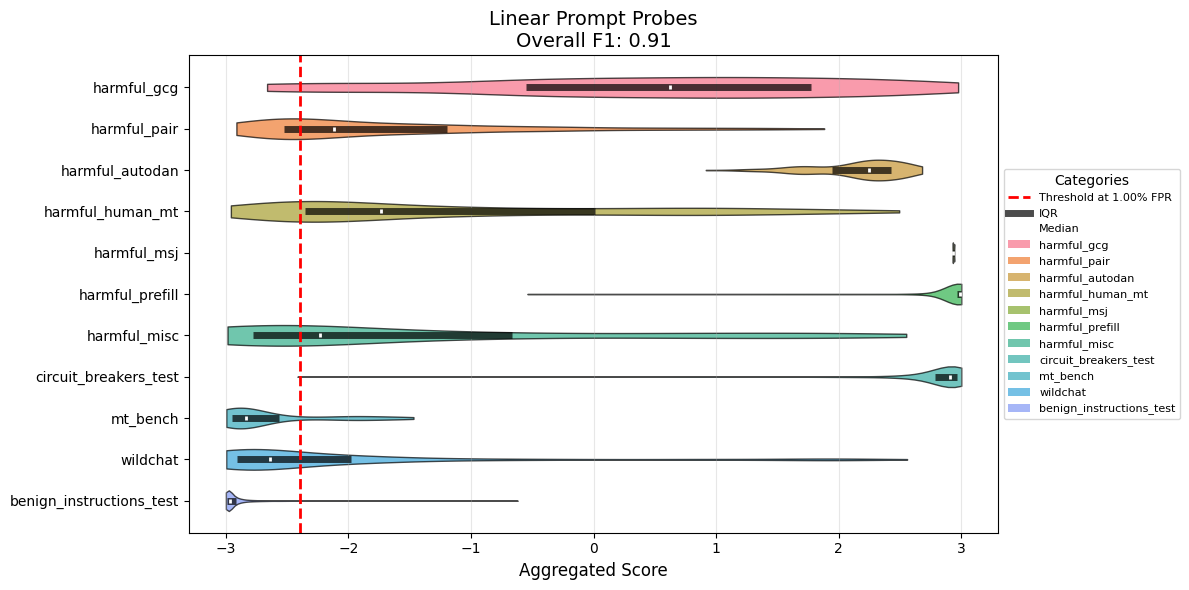

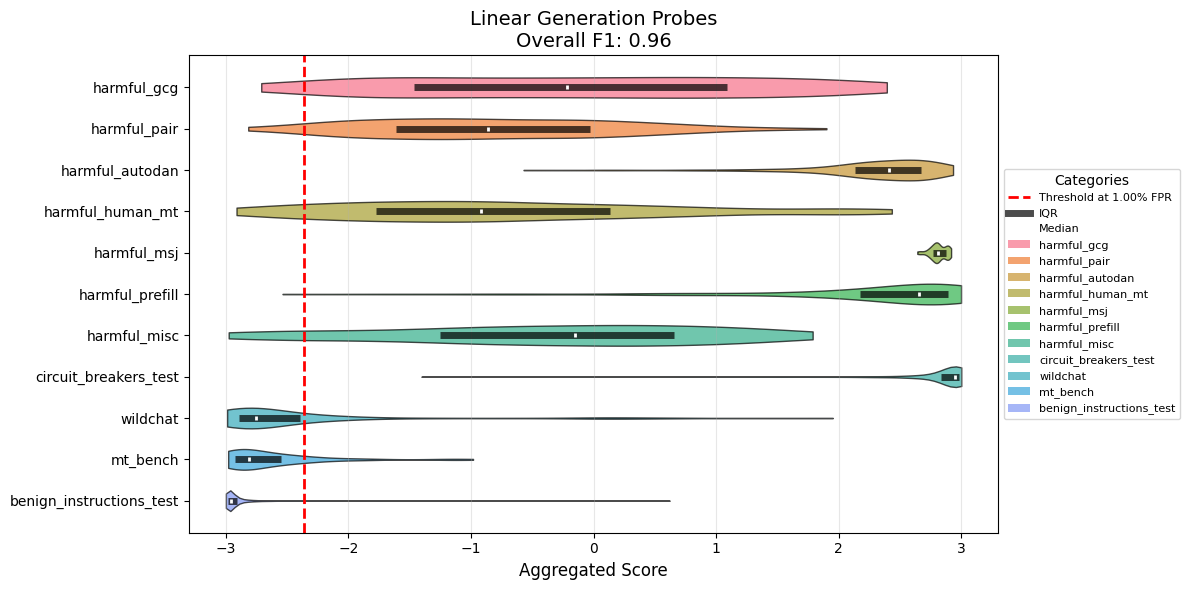

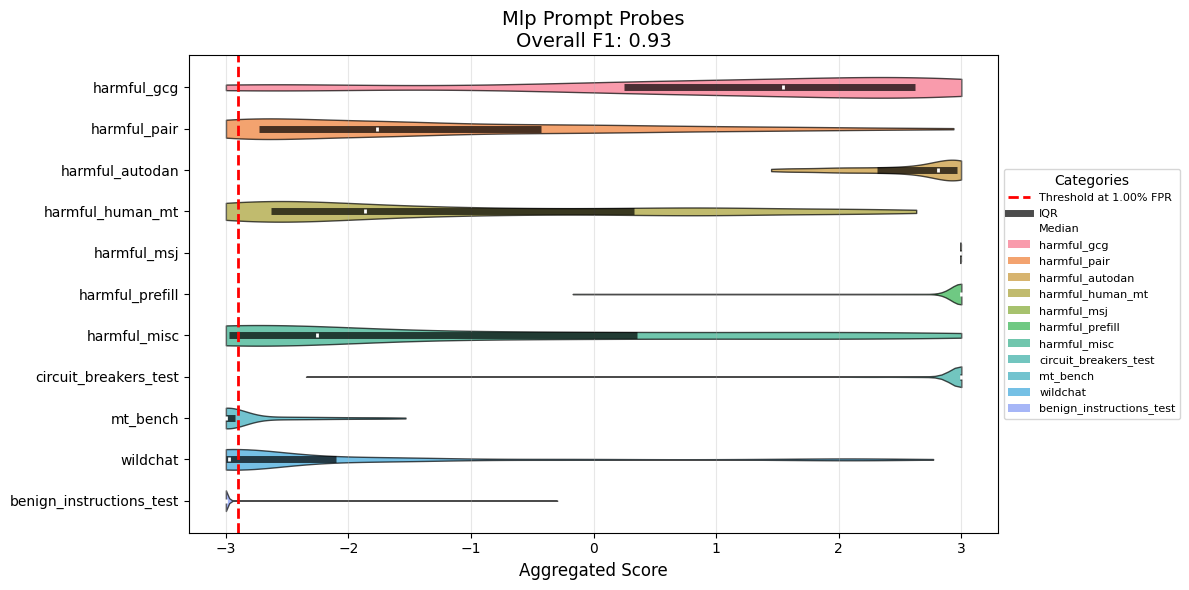

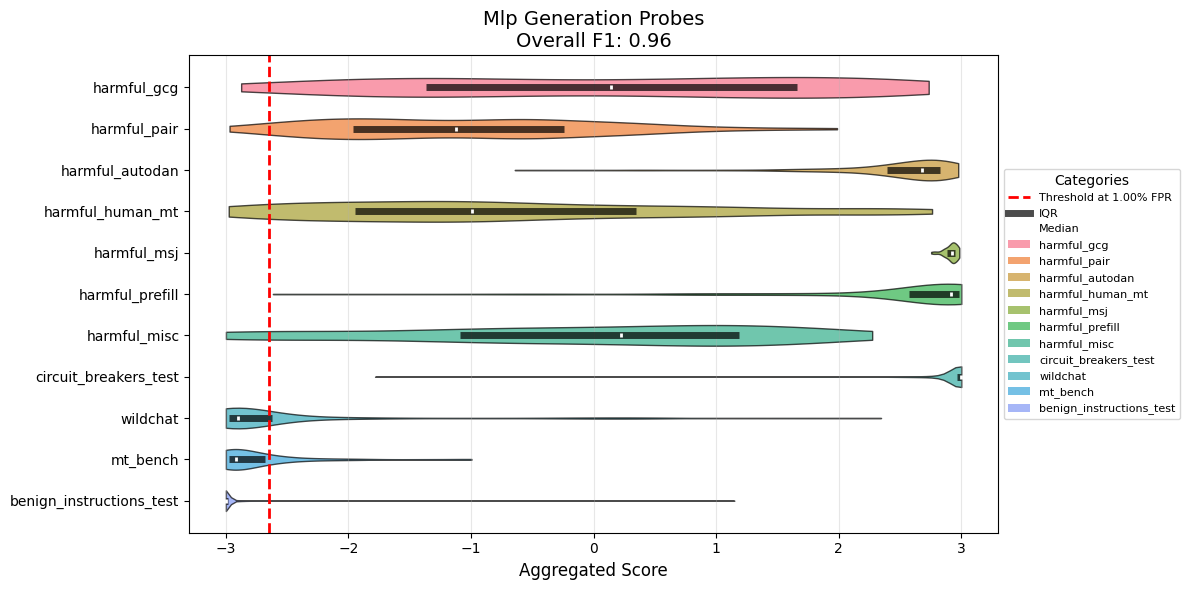

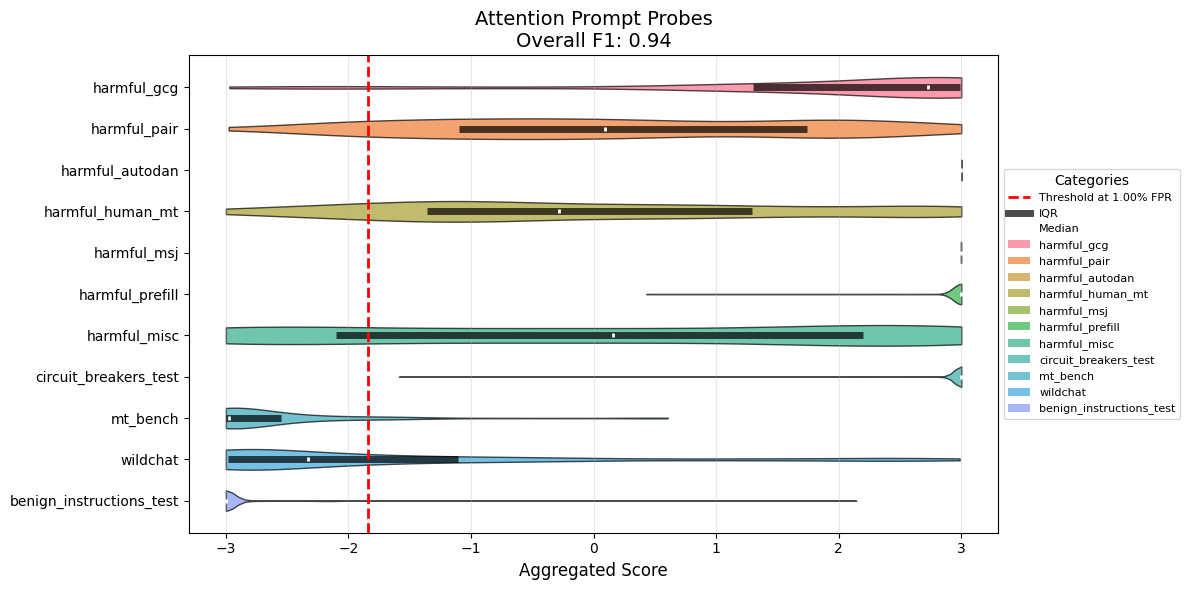

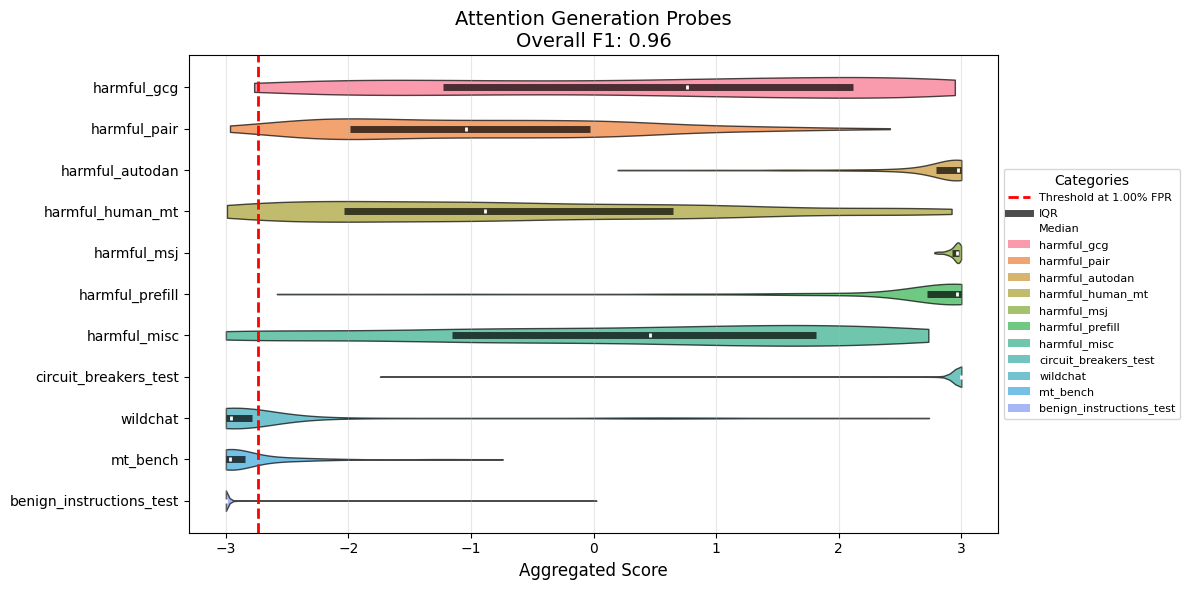

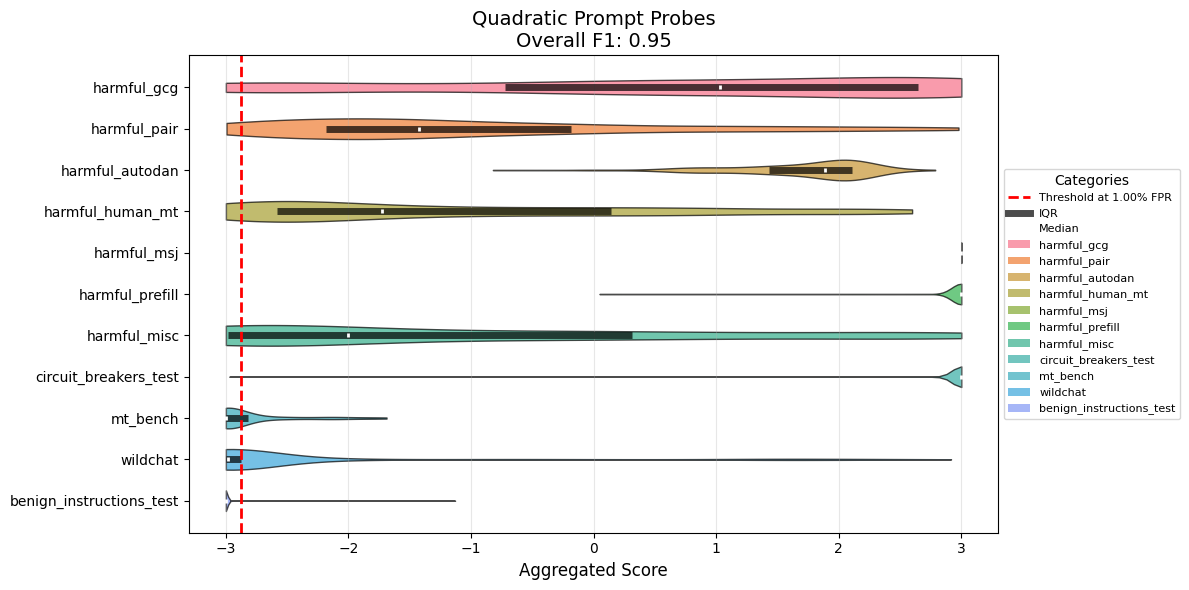

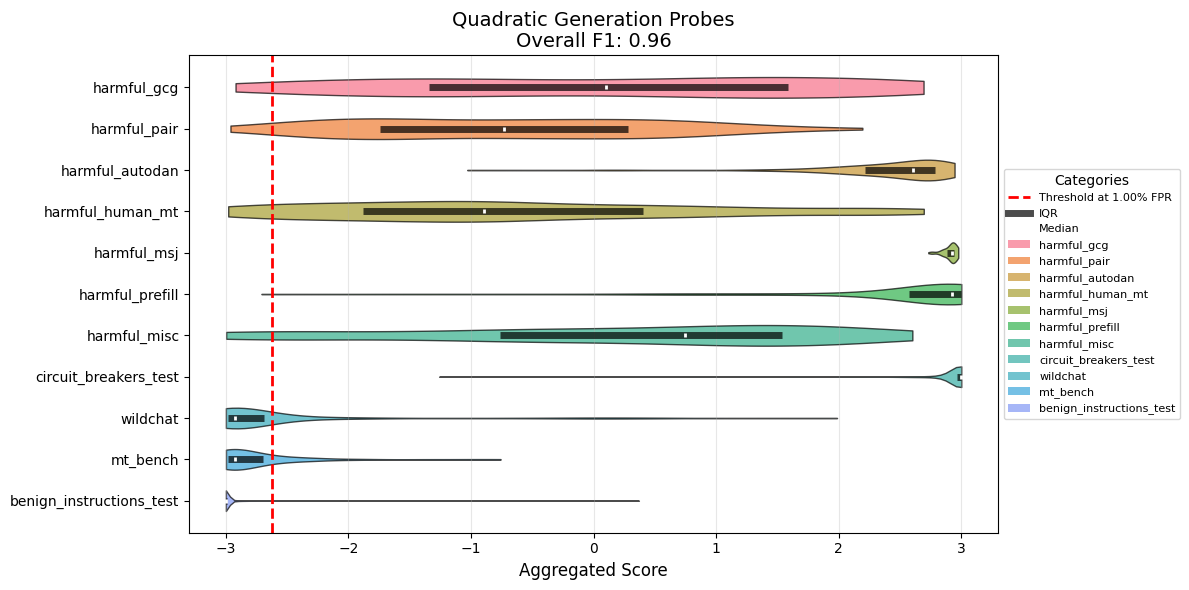

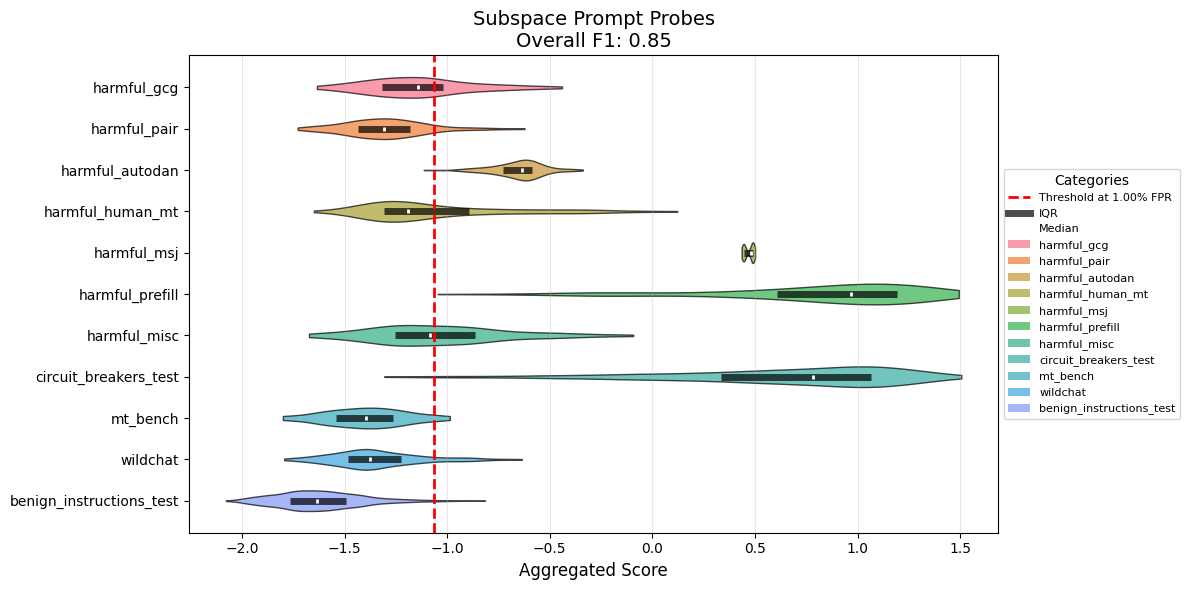

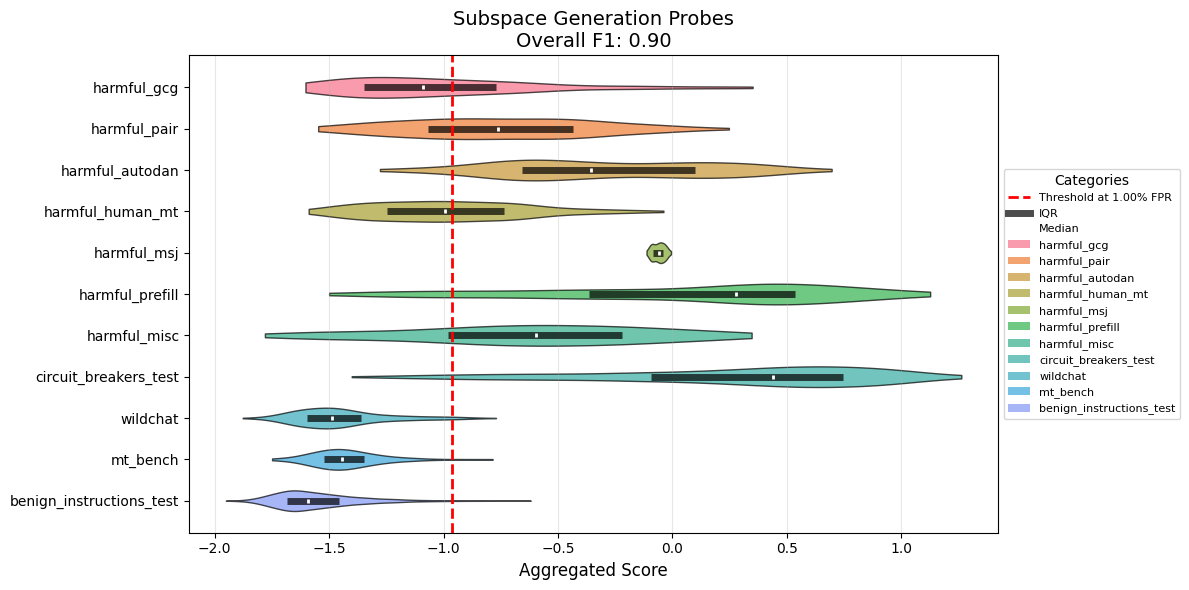

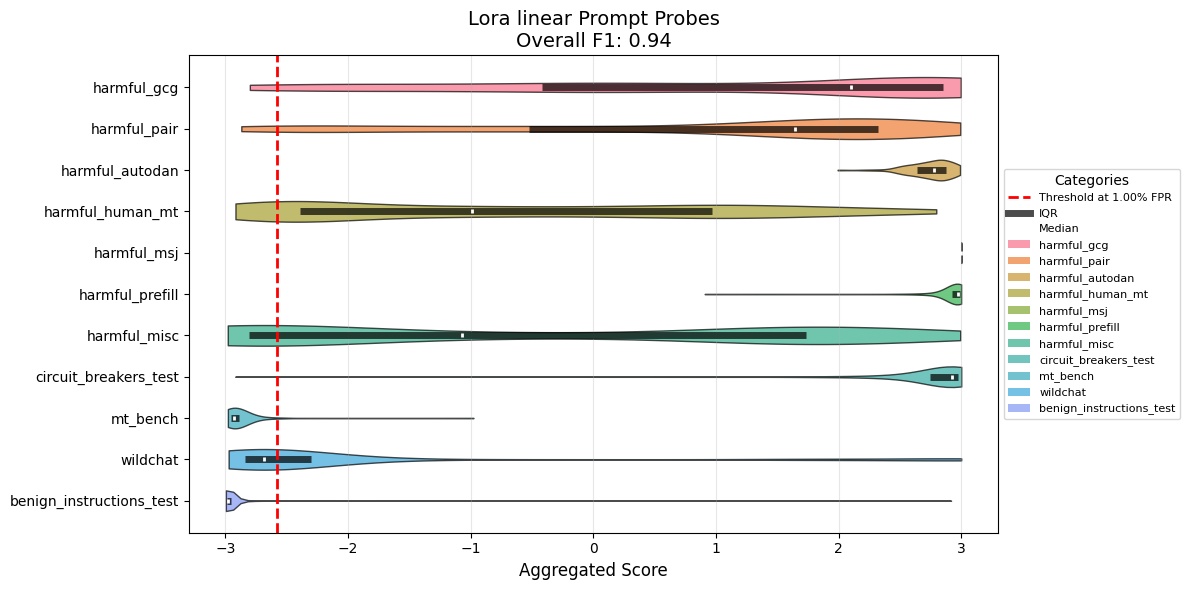

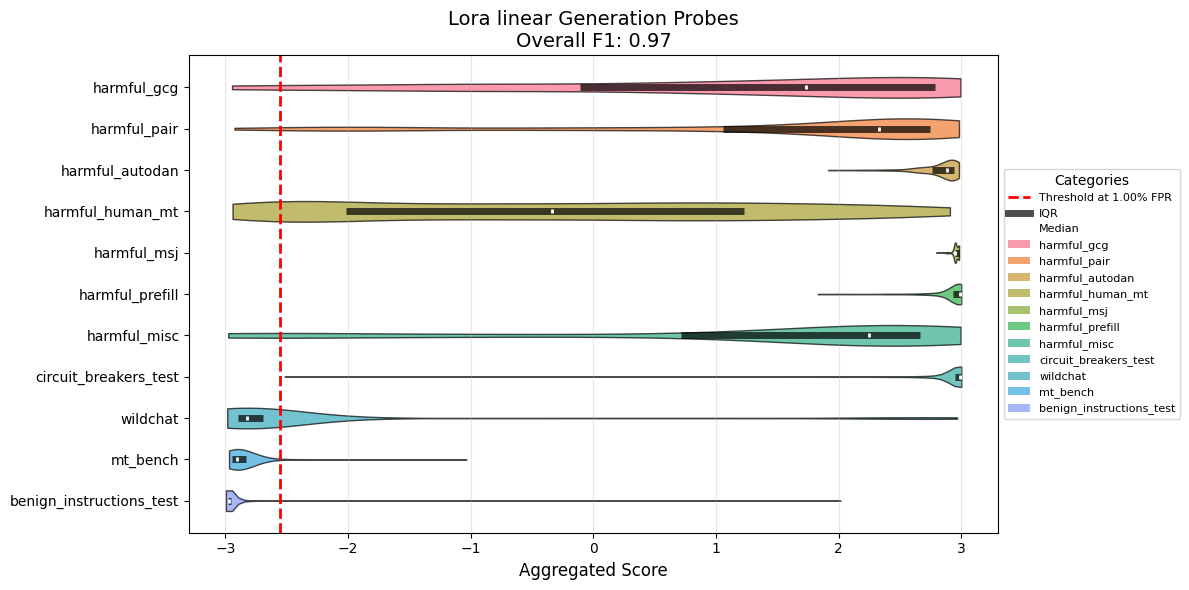

In [12]:
def get_per_split_scores(scores_dict, title):
    def check_start(index, token, tokens):
        if index < 1 or index >= len(tokens) - 1:
            return False
        return tokens[index + 1] == "\n\n" and tokens[index - 1] == "assistant"

    def input_detection(index, token, tokens):
        if index < 3 or index >= len(tokens) - 1:
            return False
        return tokens[index - 1] == "\n\n" and tokens[index - 3] == "assistant"

    def generation_detection(index, token, tokens):
        return token == "<|eot_id|>"

    prompt_scores_dict = remove_scores_between_tokens(
        scores_dict, [check_start, input_detection]
    )

    generation_scores_dict = remove_scores_between_tokens(
        scores_dict, [check_start, generation_detection]
    )

    (
        prompt_data,
        prompt_labels,
        prompt_threshold,
        prompt_f1_score,
        prompt_per_split_scores,
    ) = generate_score_plots(
        all_split_scores=prompt_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "harmful_misc",
            "circuit_breakers_test",
        ],
        negative_splits=[
            "mt_bench",
            "wildchat",
        ],  # "or_bench_test", ],
        heldout_splits=["benign_instructions_test"],
        #layers=[4, 8, 12, 16, 20, 24],
        # choose all available layer
        layers=list(prompt_scores_dict["harmful_gcg"].keys()),
        cross_token_aggregation="mean",
        cross_layer_aggregation="mean",
        title=f"{title.capitalize()} Prompt Probes",
        false_positive_rate=0.01,
    )
    prompt_dict = {label: data for data, label in zip(prompt_data, prompt_labels)}

    (
        generation_data,
        generation_labels,
        generation_threshold,
        generation_f1_score,
        generation_per_split_scores,
    ) = generate_score_plots(
        all_split_scores=generation_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "harmful_misc",
            "circuit_breakers_test",
        ],
        negative_splits=[
            #"benign_instructions_test",
            "wildchat",
            "mt_bench"
        ],  # "or_bench_test", ],
        heldout_splits=["benign_instructions_test"],
        #layers=[4, 8, 12, 16, 20, 24],
        layers=list(generation_scores_dict["harmful_gcg"].keys()),
        cross_token_aggregation="mean",
        cross_layer_aggregation="mean",
        title=f"{title.capitalize()} Generation Probes",
        false_positive_rate=0.01,
    )
    generation_dict = {label: data for data, label in zip(generation_data, generation_labels)}

    return prompt_per_split_scores, generation_per_split_scores, prompt_dict, generation_dict


mean_diff_prompt_per_split_scores, mean_diff_generation_per_split_scores, mean_diff_prompt_data, mean_diff_generation_data = (
    get_per_split_scores(mean_diff_scores_dict, "mean_diff")
)
linear_prompt_per_split_scores, linear_generation_per_split_scores, linear_prompt_data, linear_generation_data = (
    get_per_split_scores(linear_scores_dict, "linear")
)
mlp_prompt_per_split_scores, mlp_generation_per_split_scores, mlp_prompt_data, mlp_generation_data = get_per_split_scores(
    mlp_scores_dict, "mlp"
)
attention_prompt_per_split_scores, attention_generation_per_split_scores, attention_prompt_data, attention_generation_data = (
    get_per_split_scores(attention_scores_dict, "attention")
)
quadratic_prompt_per_split_scores, quadratic_generation_per_split_scores, quadratic_prompt_data, quadratic_generation_data = (
    get_per_split_scores(quadratic_scores_dict, "quadratic")
)
subspace_prompt_per_split_scores, subspace_generation_per_split_scores, subspace_prompt_data, subspace_generation_data = (
    get_per_split_scores(subspace_scores_dict, "subspace")
)
lora_linear_prompt_per_split_scores, lora_linear_generation_per_split_scores, lora_linear_prompt_data, lora_linear_generation_data = (
    get_per_split_scores(lora_linear_scores_dict, "lora linear")
)

### Final Results Table

In [17]:
import pandas as pd
import numpy as np

# Create dictionaries for each probe type and task
data = {
    "Mean Diff": {
        "Instruction": mean_diff_prompt_per_split_scores,
        "Generation": mean_diff_generation_per_split_scores,
    },
    "LogReg": {
        "Instruction": linear_prompt_per_split_scores,
        "Generation": linear_generation_per_split_scores,
    },
    "Quadratic": {
        "Instruction": quadratic_prompt_per_split_scores,
        "Generation": quadratic_generation_per_split_scores,
    },
    "MLP": {
        "Instruction": mlp_prompt_per_split_scores,
        "Generation": mlp_generation_per_split_scores,
    },
    #"Subspace": {
    #    "Instruction": subspace_prompt_per_split_scores,
    #    "Generation": subspace_generation_per_split_scores,
    #},
    #"Attention": {
    #    "Instruction": attention_prompt_per_split_scores,
    #    "Generation": attention_generation_per_split_scores,
    #},
    #"LoRA + Linear": {
    #    "Instruction": lora_linear_prompt_per_split_scores,
    #    "Generation": lora_linear_generation_per_split_scores,
    #},
    #"LoRA + OAT Linear": {
    #    "Instruction": lora_at_linear_prompt_per_split_scores,
    #    "Generation": lora_at_linear_generation_per_split_scores,
    #},
}

# Define column order
jailbreak_columns = [
    "GCG",
    "PAIR",
    "AutoDAN",
    "Multi-Turn",
    "Many-Shot",
    "Misc",
    "Prefill",
   # "Circuit Breakers",
]
benign_columns = ["UltraChat*", "WildChat", "MT-Bench"]

# Create MultiIndex for columns
column_tuples = (
    [("Jailbreak", col) for col in jailbreak_columns]
    + [("Jailbreak", "Average")]
    + [("Benign", col) for col in benign_columns]
    + [("Benign", "Average")]
)
columns = pd.MultiIndex.from_tuples(column_tuples)

# Create MultiIndex for rows
index = pd.MultiIndex.from_product([data.keys(), ["Instruction", "Generation"]])

# Create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)

# Fill DataFrame
for probe, tasks in data.items():
    for task, scores in tasks.items():
        for col in jailbreak_columns + benign_columns:
            col_name = col[:-1] if col.endswith("*") else col
            original_col = {
                "GCG": "harmful_gcg",
                "PAIR": "harmful_pair",
                "AutoDAN": "harmful_autodan",
                "Multi-Turn": "harmful_human_mt",
                "Many-Shot": "harmful_msj",
                "Prefill": "harmful_prefill",
                "Misc": "harmful_misc",
                "Circuit Breakers": "circuit_breakers_test",
                "UltraChat*": "benign_instructions_test",
                "WildChat": "wildchat",
                "MT-Bench": "mt_bench",
            }[col]
            if original_col in scores:
                df.loc[
                    (probe, task),
                    ("Jailbreak" if col in jailbreak_columns else "Benign", col),
                ] = (
                    scores[original_col] * 100
                )

# Calculate averages
df[("Jailbreak", "Average")] = df["Jailbreak"].mean(axis=1)
df[("Benign", "Average")] = df["Benign"].mean(axis=1)

# Format numbers
df = df.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")

# Display the table
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print(df.to_string())

                      Jailbreak                                                                Benign                          
                            GCG   PAIR AutoDAN Multi-Turn Many-Shot   Misc Prefill Average UltraChat* WildChat MT-Bench Average
Mean Diff Instruction     16.48   0.38    0.00      32.99    100.00  28.75   98.98   39.66      99.00   100.00    97.47   98.82
          Generation      63.74  23.11   95.90      53.95    100.00  75.00   91.88   71.94      99.03    88.38    93.67   93.70
LogReg    Instruction     92.31  64.02  100.00      76.29    100.00  58.75  100.00   84.48      99.00    61.83    78.48   79.77
          Generation      95.60  95.45  100.00      89.69    100.00  87.50   99.49   95.39      99.03    76.97    83.54   86.52
Quadratic Instruction     87.91  94.32  100.00      86.94    100.00  71.25  100.00   91.49      99.00    74.69    70.89   81.52
          Generation      95.60  96.21  100.00      90.03    100.00  90.00   99.49   95.91      99.03   

/tmp/ipykernel_1578174/3666816574.py:99: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")


In [20]:
import pandas as pd
import numpy as np

# Create dictionaries for each probe type and task
data = {
    "Mean Diff": {
        "Instruction": mean_diff_prompt_per_split_scores,
        "Generation": mean_diff_generation_per_split_scores,
    },
    "LogReg": {
        "Instruction": linear_prompt_per_split_scores,
        "Generation": linear_generation_per_split_scores,
    },
    "Quadratic": {
        "Instruction": quadratic_prompt_per_split_scores,
        "Generation": quadratic_generation_per_split_scores,
    },
    "MLP": {
        "Instruction": mlp_prompt_per_split_scores,
        "Generation": mlp_generation_per_split_scores,
    },
}

# Define column order
jailbreak_columns = [
    "GCG",
    "PAIR",
    "AutoDAN",
    "Many-Shot",
    "Multi-Turn",
    "Prefill",
    "Misc.",
]

# Create MultiIndex for columns
column_tuples = [("Jailbreak", col) for col in jailbreak_columns] + [("Jailbreak", "Average")]
columns = pd.MultiIndex.from_tuples(column_tuples)

# Create MultiIndex for rows
index = pd.MultiIndex.from_product([data.keys(), ["Instruction", "Generation"]])

# Create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)

# Fill DataFrame
for probe, tasks in data.items():
    for task, scores in tasks.items():
        for col in jailbreak_columns:
            original_col = {
                "GCG": "harmful_gcg",
                "PAIR": "harmful_pair",
                "AutoDAN": "harmful_autodan",
                "Multi-Turn": "harmful_human_mt",
                "Many-Shot": "harmful_msj",
                "Prefill": "harmful_prefill",
                "Misc.": "harmful_misc",
            }[col]
            if original_col in scores:
                df.loc[(probe, task), ("Jailbreak", col)] = scores[original_col] * 100

# Calculate average
df[("Jailbreak", "Average")] = df["Jailbreak"].mean(axis=1)

# Format numbers
df = df.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")

# Display the table
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

                      Jailbreak                                                           
                            GCG   PAIR AutoDAN Many-Shot Multi-Turn Prefill  Misc. Average
Mean Diff Instruction     16.48   0.38    0.00    100.00      32.99   98.98  28.75   39.66
          Generation      63.74  23.11   95.90    100.00      53.95   91.88  75.00   71.94
LogReg    Instruction     92.31  64.02  100.00    100.00      76.29  100.00  58.75   84.48
          Generation      95.60  95.45  100.00    100.00      89.69   99.49  87.50   95.39
Quadratic Instruction     87.91  94.32  100.00    100.00      86.94  100.00  71.25   91.49
          Generation      95.60  96.21  100.00    100.00      90.03   99.49  90.00   95.91
MLP       Instruction     95.60  83.33  100.00    100.00      87.29  100.00  66.25   90.35
          Generation      96.70  96.59  100.00    100.00      90.72  100.00  90.00   96.29


/tmp/ipykernel_1578174/201255542.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")


In [14]:
# Jointly save the table and the relevant scores for further analysis
df.to_csv("llama3_probes_scores.csv")

with open("llama3_probes_scores.json", "w") as f:
    all_data_scores = {
        "mean_diff_prompt": mean_diff_prompt_data,
        "mean_diff_generation": mean_diff_generation_data,
        "linear_prompt": linear_prompt_data,
        "linear_generation": linear_generation_data,
        "quadratic_prompt": quadratic_prompt_data,
        "quadratic_generation": quadratic_generation_data,
        "mlp_prompt": mlp_prompt_data,
        "mlp_generation": mlp_generation_data,
        "attention_prompt": attention_prompt_data,
        "attention_generation": attention_generation_data,
    }
    
    json.dump(all_data_scores, f)


In [15]:
df

Jailbreak                                             \
                            GCG   PAIR AutoDAN Multi-Turn Many-Shot   Misc   
Mean Diff Instruction     16.48   0.38    0.00      32.99    100.00  28.75   
          Generation      63.74  23.11   95.90      53.95    100.00  75.00   
LogReg    Instruction     92.31  64.02  100.00      76.29    100.00  58.75   
          Generation      95.60  95.45  100.00      89.69    100.00  87.50   
Quadratic Instruction     87.91  94.32  100.00      86.94    100.00  71.25   
          Generation      95.60  96.21  100.00      90.03    100.00  90.00   
MLP       Instruction     95.60  83.33  100.00      87.29    100.00  66.25   
          Generation      96.70  96.59  100.00      90.72    100.00  90.00   
Attention Instruction     92.31  87.88  100.00      85.22    100.00  72.50   
          Generation      97.80  97.35  100.00      91.75    100.00  88.75   

                                          Benign                            
                      Prefill Average UltraChat* WildChat MT-Bench Average  
Mean Diff Instruction   98.98   39.66      99.00   100.00    97.47   98.82  
          Generation    91.88   71.94      99.03    88.38    93.67   93.70  
LogReg    Instruction  100.00   84.48      99.00    61.83    78.48   79.77  
          Generation    99.49   95.39      99.03    76.97    83.54   86.52  
Quadratic Instruction  100.00   91.49      99.00    74.69    70.89   81.52  
          Generation    99.49   95.91      99.03    77.80    78.48   85.11  
MLP       Instruction  100.00   90.35      99.07    57.26    75.95   77.43  
          Generation   100.00   96.29      99.00    73.86    77.22   83.36  
Attention Instruction  100.00   91.13      99.00    65.56    87.34   83.97  
          Generation   100.00   96.52      99.03    78.42    75.95   84.47